# PROJET STT-3795 | Système de Recommandation Content-Based
## Filtrage Basé sur le Contenu - MovieLens 100K

**Objectifs :**
- Développer un système de recommandation basé sur les caractéristiques des films
- Implémenter différentes méthodes de calcul de similarité
- Analyser l'impact des pondérations par popularité et qualité
- Évaluer les performances et la diversité des recommandations
- Créer des profils utilisateurs basés sur leurs préférences de contenu

**Principe du Content-Based Filtering :**
Le filtrage basé sur le contenu recommande des films similaires à ceux qu'un utilisateur a déjà appréciés, 
en se basant sur les caractéristiques intrinsèques des films (genres, métadonnées).

**Avantages :**
- Pas de problème de cold start pour les nouveaux utilisateurs
- Explications transparentes des recommandations
- Diversité contrôlable via les caractéristiques

**Inconvénients :**
- Risque de sur-spécialisation (filter bubble)
- Limité par la qualité des métadonnées disponibles
- Difficulté à découvrir des contenus vraiment nouveaux

**Auteur :** [Votre nom]  
**Date :** [Date actuelle]

## 1. Configuration et Import des Modules

Importation de tous les modules nécessaires, y compris notre classe personnalisée ContentBasedRecommender.

In [1]:
# Imports standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from typing import List, Dict, Tuple

# Import de nos modules personnalisés
from content_based_utils import (
    ContentBasedRecommender,
    analyze_content_features,
    plot_genre_analysis,
    evaluate_content_recommendations,
    create_movie_profile_visualization,
    compare_similarity_metrics,
    enhance_movies_with_metadata
)

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("🚀 Modules importés avec succès !")

🚀 Modules importés avec succès !


## 2. Chargement et Préparation des Données

Chargement des données MovieLens et préparation pour le système content-based.

In [2]:
# Chargement des données (adapté à votre structure de données existante)
print("📊 Chargement des données MovieLens...")

# Supposons que vous avez déjà vos DataFrames depuis l'analyse exploratoire
try:
    # Chargement depuis les fichiers CSV traités ou directement depuis les sources
    ratings_df = pd.read_csv('processed_data/ratings_enriched.csv')
    movies_df = pd.read_csv('ml-100k/u.item', 
                           sep='|', 
                           encoding='latin1',
                           names=['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
                                 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
                                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
    
    print("✅ Données chargées depuis les fichiers traités")
except FileNotFoundError:
    # Chargement direct depuis les sources originales
    ratings_df = pd.read_csv('ml-100k/u.data', 
                           sep='\t', 
                           names=['user_id', 'movie_id', 'rating', 'timestamp'])
    
    movies_df = pd.read_csv('ml-100k/u.item', 
                           sep='|', 
                           encoding='latin1',
                           names=['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
                                 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
                                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
    
    print("✅ Données chargées depuis les sources originales")

# Affichage des informations de base
print(f"\n📈 Statistiques des données :")
print(f"• Films : {len(movies_df):,}")
print(f"• Évaluations : {len(ratings_df):,}")
print(f"• Utilisateurs uniques : {ratings_df['user_id'].nunique():,}")

# Aperçu des données
print(f"\n🎬 Aperçu des films :")
display(movies_df.head())

print(f"\n⭐ Aperçu des évaluations :")
display(ratings_df.head())

📊 Chargement des données MovieLens...
✅ Données chargées depuis les fichiers traités

📈 Statistiques des données :
• Films : 1,682
• Évaluations : 100,000
• Utilisateurs uniques : 943

🎬 Aperçu des films :


,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0



⭐ Aperçu des évaluations :


,user_id,movie_id,rating,timestamp,datetime,date,year,month,day_of_week,hour
0,196,242,3,881250949,1997-12-04 15:55:49,1997-12-04,1997,12,Thursday,15
1,186,302,3,891717742,1998-04-04 19:22:22,1998-04-04,1998,4,Saturday,19
2,22,377,1,878887116,1997-11-07 07:18:36,1997-11-07,1997,11,Friday,7
3,244,51,2,880606923,1997-11-27 05:02:03,1997-11-27,1997,11,Thursday,5
4,166,346,1,886397596,1998-02-02 05:33:16,1998-02-02,1998,2,Monday,5


### 2.1 Enrichissement des Métadonnées

Extraction d'informations supplémentaires depuis les données existantes pour améliorer 
la qualité des recommandations.

In [3]:
# Enrichissement des métadonnées des films
print("🔧 Enrichissement des métadonnées...")

enhanced_movies_df = enhance_movies_with_metadata(movies_df)

print(f"✅ Métadonnées enrichies ! Nouvelles colonnes ajoutées :")
new_columns = set(enhanced_movies_df.columns) - set(movies_df.columns)
for col in new_columns:
    print(f"• {col}")

print(f"\n📊 Répartition par décennie :")
decade_dist = enhanced_movies_df['decade'].value_counts().sort_index()
for decade, count in decade_dist.head(10).items():
    if not pd.isna(decade):
        print(f"• {int(decade)}s : {count} films")

print(f"\n🎭 Répartition par ère cinématographique :")
era_dist = enhanced_movies_df['era'].value_counts()
for era, count in era_dist.items():
    print(f"• {era} : {count} films")

# Aperçu des données enrichies
display(enhanced_movies_df[['title', 'year', 'decade', 'era', 'primary_genre', 'genre_count']].head(10))

🔧 Enrichissement des métadonnées...
✅ Métadonnées enrichies ! Nouvelles colonnes ajoutées :
• decade
• era
• primary_genre
• genre_count
• year

📊 Répartition par décennie :
• 1920s : 2 films
• 1930s : 29 films
• 1940s : 45 films
• 1950s : 57 films
• 1960s : 46 films
• 1970s : 55 films
• 1980s : 110 films
• 1990s : 1337 films

🎭 Répartition par ère cinématographique :
• Blockbuster Era : 1447 films
• Golden Age : 131 films
• New Hollywood : 101 films
• Silent Era : 2 films
• Unknown : 1 films


,title,year,decade,era,primary_genre,genre_count
0,Toy Story (1995),1995.0,1990,Blockbuster Era,Animation,3
1,GoldenEye (1995),1995.0,1990,Blockbuster Era,Action,3
2,Four Rooms (1995),1995.0,1990,Blockbuster Era,Thriller,1
3,Get Shorty (1995),1995.0,1990,Blockbuster Era,Action,3
4,Copycat (1995),1995.0,1990,Blockbuster Era,Crime,3
5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995.0,1990,Blockbuster Era,Drama,1
6,Twelve Monkeys (1995),1995.0,1990,Blockbuster Era,Drama,2
7,Babe (1995),1995.0,1990,Blockbuster Era,Children's,3
8,Dead Man Walking (1995),1995.0,1990,Blockbuster Era,Drama,1
9,Richard III (1995),1995.0,1990,Blockbuster Era,Drama,2


## 3. Analyse des Caractéristiques de Contenu

Avant de construire notre système de recommandation, analysons les caractéristiques 
de contenu disponibles dans notre dataset.

In [4]:
# Identification des colonnes de genres
genre_columns = [col for col in movies_df.columns 
                if col not in ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']]

print(f"🎭 Genres identifiés ({len(genre_columns)}) :")
print(genre_columns)

# Analyse complète des caractéristiques de contenu
content_analysis = analyze_content_features(enhanced_movies_df, genre_columns)

print(f"\n📊 ANALYSE DES CARACTÉRISTIQUES DE CONTENU")
print("=" * 50)

print(f"\n🎬 Statistiques générales :")
print(f"• Genres moyens par film : {content_analysis['avg_genres_per_movie']:.2f}")
print(f"• Maximum de genres par film : {content_analysis['max_genres_per_movie']}")
print(f"• Films sans genre : {content_analysis['movies_without_genre']}")

print(f"\n🏆 Top 10 des genres les plus fréquents :")
for genre, count in list(content_analysis['genre_distribution'].items())[:10]:
    percentage = (count / len(movies_df)) * 100
    print(f"• {genre:<15} : {count:4} films ({percentage:5.1f}%)")

print(f"\n🎯 Top 10 des combinaisons de genres :")
for combo, count in content_analysis['top_genre_combinations']:
    percentage = (count / len(movies_df)) * 100
    print(f"• {combo:<25} : {count:3} films ({percentage:4.1f}%)")

🎭 Genres identifiés (19) :
['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

📊 ANALYSE DES CARACTÉRISTIQUES DE CONTENU

🎬 Statistiques générales :
• Genres moyens par film : 1.72
• Maximum de genres par film : 6
• Films sans genre : 0

🏆 Top 10 des genres les plus fréquents :
• Drama           :  725 films ( 43.1%)
• Comedy          :  505 films ( 30.0%)
• Action          :  251 films ( 14.9%)
• Thriller        :  251 films ( 14.9%)
• Romance         :  247 films ( 14.7%)
• Adventure       :  135 films (  8.0%)
• Children's      :  122 films (  7.3%)
• Crime           :  109 films (  6.5%)
• Sci-Fi          :  101 films (  6.0%)
• Horror          :   92 films (  5.5%)

🎯 Top 10 des combinaisons de genres :
• Drama                     : 376 films (22.4%)
• Comedy                    : 210 films (12.5%)
• Comedy+Romance         

### 3.1 Visualisation des Caractéristiques

Créons des visualisations pour mieux comprendre la distribution des genres et leurs relations.

📈 Création des visualisations...


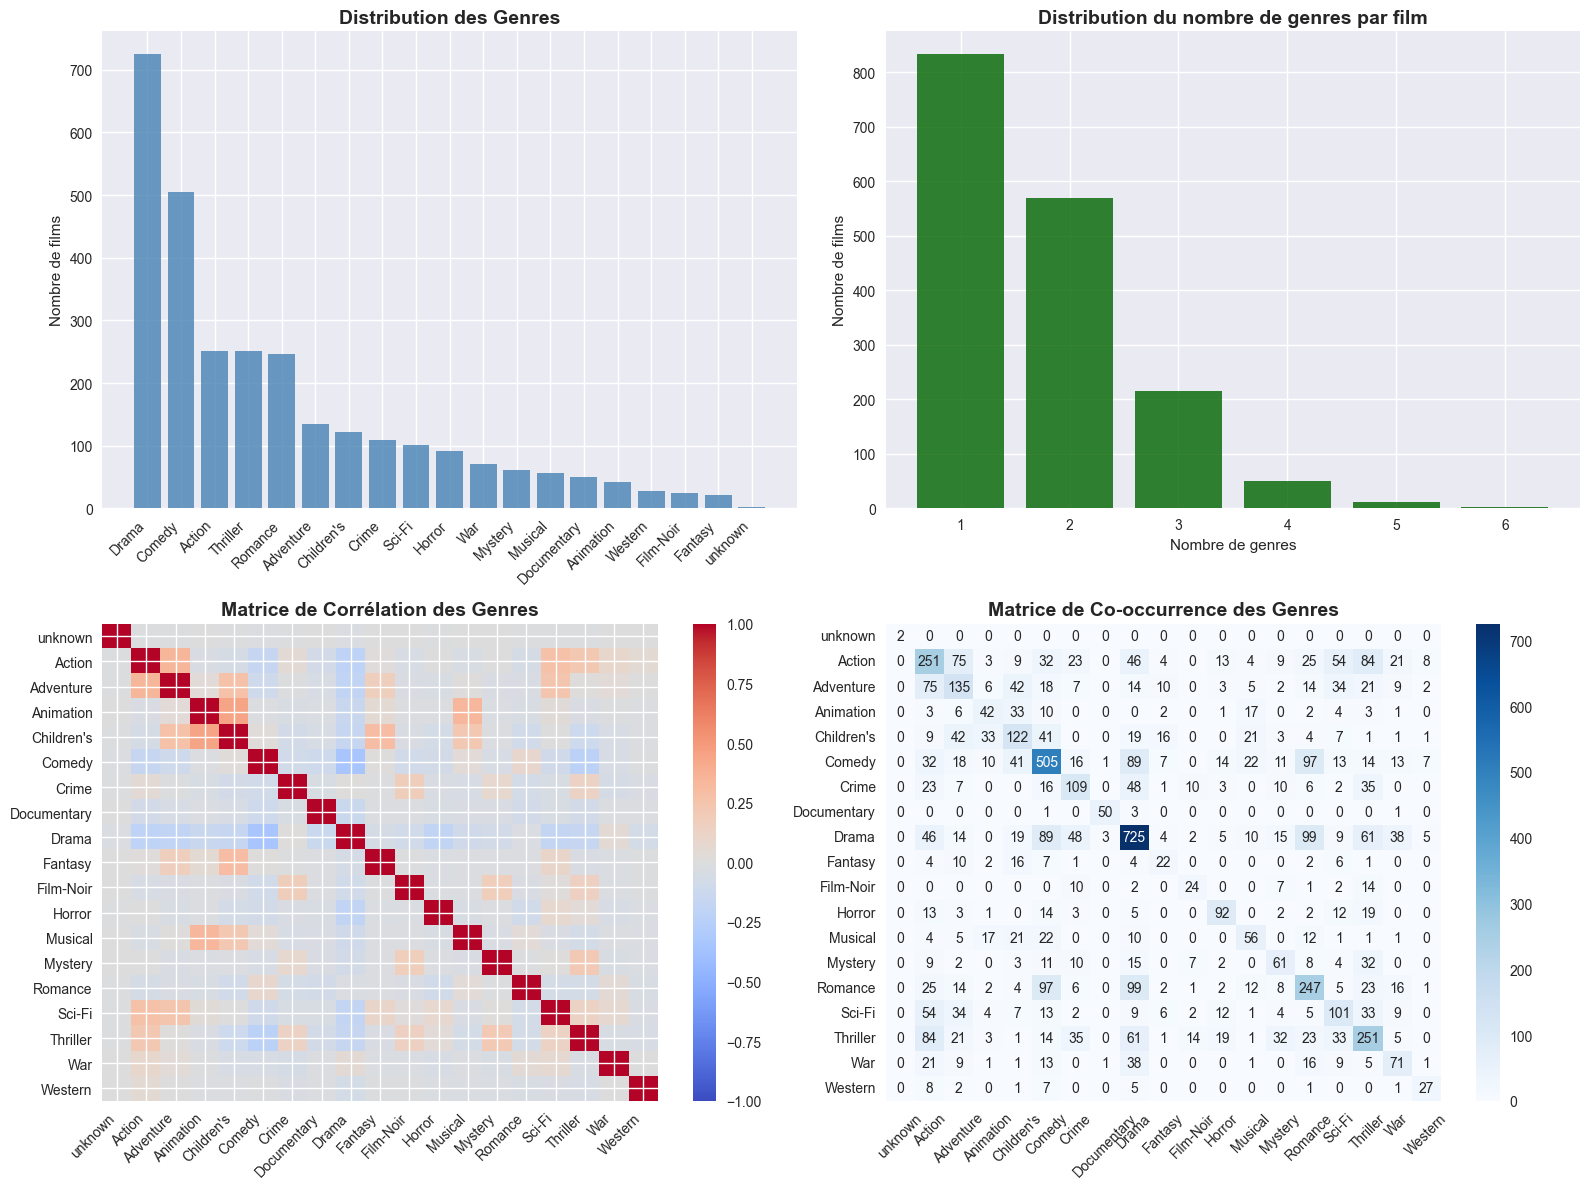

In [5]:
# Visualisation complète de l'analyse des genres
print("📈 Création des visualisations...")
plot_genre_analysis(enhanced_movies_df, genre_columns, save_path="figures/genre_analysis_detailed.png")

## 4. Construction du Système de Recommandation Content-Based

Initialisons notre système de recommandation et testons différentes approches.

In [6]:
# Initialisation du système de recommandation
print("🤖 Initialisation du système de recommandation content-based...")

# Création de l'instance principale
cb_recommender = ContentBasedRecommender(enhanced_movies_df, ratings_df)

print(f"✅ Système initialisé !")
print(f"• Genres détectés : {len(cb_recommender.genre_columns)}")
print(f"• Films dans la base : {len(cb_recommender.movies_df)}")
print(f"• Statistiques de films calculées : {'Oui' if cb_recommender.movie_stats is not None else 'Non'}")

# Aperçu des statistiques calculées
if cb_recommender.movie_stats is not None:
    print(f"\n📊 Aperçu des statistiques par film :")
    display(cb_recommender.movie_stats.head())

🤖 Initialisation du système de recommandation content-based...
✅ Système initialisé !
• Genres détectés : 21
• Films dans la base : 1682
• Statistiques de films calculées : Oui

📊 Aperçu des statistiques par film :


,movie_id,rating_count,rating_mean,rating_std,rating_median
0,1,452,3.878,0.928,4.0
1,2,131,3.206,0.966,3.0
2,3,90,3.033,1.213,3.0
3,4,209,3.550,0.965,4.0
4,5,86,3.302,0.946,3.0


### 4.1 Comparaison des Méthodes de Création de Caractéristiques

Testons différentes méthodes pour créer la matrice de caractéristiques et comparons leurs effets.

In [7]:
# Test des différentes méthodes de création de caractéristiques
methods = ['basic', 'weighted', 'tfidf', 'normalized']
method_results = {}

print("🧪 Test des différentes méthodes de caractéristiques...")
print("=" * 55)

for method in methods:
    try:
        print(f"\n🔬 Méthode : {method.upper()}")
        
        # Création de la matrice de caractéristiques
        feature_matrix = cb_recommender.create_feature_matrix(
            method=method,
            rating_weight=1.2,
            popularity_weight=0.8,
            min_ratings=5
        )
        
        print(f"• Forme de la matrice : {feature_matrix.shape}")
        print(f"• Sparsité : {(feature_matrix == 0).sum() / feature_matrix.size:.2%}")
        print(f"• Moyenne des valeurs : {np.mean(feature_matrix):.4f}")
        print(f"• Écart-type : {np.std(feature_matrix):.4f}")
        
        # Calcul de la similarité cosinus
        cb_recommender.compute_similarity_matrix(metric='cosine')
        
        # Test sur un film populaire
        test_movie = "Toy Story (1995)"
        if test_movie in cb_recommender.movies_df['title'].values:
            recs = cb_recommender.get_movie_recommendations(test_movie, 5)
            avg_similarity = recs['similarity_score'].mean()
            print(f"• Similarité moyenne pour '{test_movie}' : {avg_similarity:.4f}")
            
            method_results[method] = {
                'avg_similarity': avg_similarity,
                'feature_std': np.std(feature_matrix),
                'recommendations': recs['title'].tolist()
            }
        
    except Exception as e:
        print(f"❌ Erreur avec la méthode {method} : {e}")

🧪 Test des différentes méthodes de caractéristiques...

🔬 Méthode : BASIC
• Forme de la matrice : (1682, 21)
• Sparsité : 85.45%
• Moyenne des valeurs : 75.8468
• Écart-type : 380.0616
• Similarité moyenne pour 'Toy Story (1995)' : 1.0000

🔬 Méthode : WEIGHTED
• Forme de la matrice : (1682, 21)
• Sparsité : 85.45%
• Moyenne des valeurs : 164.4308
• Écart-type : 834.0835
• Similarité moyenne pour 'Toy Story (1995)' : 1.0000

🔬 Méthode : TFIDF
❌ Erreur avec la méthode tfidf : boolean value of NA is ambiguous

🔬 Méthode : NORMALIZED
• Forme de la matrice : (1682, 21)
• Sparsité : 19.80%
• Moyenne des valeurs : 0.0172
• Écart-type : 0.9245
• Similarité moyenne pour 'Toy Story (1995)' : 0.9571


### 4.2 Comparaison des Métriques de Similarité

Testons différentes métriques de similarité sur un film de référence.

In [8]:
# Comparaison des métriques de similarité
test_movie = "Star Wars (1977)"
print(f"🔬 Comparaison des métriques de similarité pour : {test_movie}")
print("=" * 65)

# Vérifier si le film existe
if test_movie not in enhanced_movies_df['title'].values:
    # Chercher un film similaire
    star_wars_movies = enhanced_movies_df[enhanced_movies_df['title'].str.contains('Star Wars', case=False)]
    if not star_wars_movies.empty:
        test_movie = star_wars_movies.iloc[0]['title']
        print(f"Film trouvé : {test_movie}")

try:
    comparison_df = compare_similarity_metrics(
        enhanced_movies_df, 
        genre_columns, 
        test_movie, 
        n_recommendations=8
    )
    
    if not comparison_df.empty:
        print(f"\n📊 Comparaison des recommandations par métrique :")
        display(comparison_df)
        
        # Analyse des différences
        print(f"\n🔍 Analyse des différences :")
        metrics = [col for col in comparison_df.columns if col not in ['rank', 'title']]
        
        for i, metric in enumerate(metrics):
            if metric in comparison_df.columns:
                avg_score = comparison_df[metric].mean()
                print(f"• {metric:<12} : Score moyen = {avg_score:.4f}")
    
except Exception as e:
    print(f"❌ Erreur lors de la comparaison : {e}")

🔬 Comparaison des métriques de similarité pour : Star Wars (1977)
Erreur avec la métrique correlation: 'float' object has no attribute 'shape'

📊 Comparaison des recommandations par métrique :


metric,rank,title,cosine,euclidean,manhattan
0,1,Alien (1979),NaN,0.290,NaN
1,1,Return of the Jedi (1983),1.0,NaN,NaN
2,1,Star Trek: The Motion Picture (1979),NaN,NaN,0.200
3,2,"African Queen, The (1951)",1.0,NaN,NaN
4,2,Alien (1979),NaN,NaN,0.143
5,2,Star Trek: The Motion Picture (1979),NaN,0.290,NaN
6,3,"Empire Strikes Back, The (1980)",1.0,NaN,NaN
7,3,"Godfather, The (1972)",NaN,NaN,0.111
8,3,Pete's Dragon (1977),NaN,0.261,NaN
9,4,Bedknobs and Broomsticks (1971),NaN,NaN,0.111



🔍 Analyse des différences :
• cosine       : Score moyen = 1.0000
• euclidean    : Score moyen = 0.2553
• manhattan    : Score moyen = 0.1262


## 5. Recommandations pour Films Spécifiques

Testons notre système sur plusieurs films de différents genres pour évaluer sa performance.

In [9]:
# Configuration du recommandeur avec la meilleure méthode trouvée
cb_recommender.create_feature_matrix(method='weighted', rating_weight=1.2, popularity_weight=0.8, min_ratings=10)
cb_recommender.compute_similarity_matrix(metric='cosine')

# Liste de films tests de différents genres
test_films = [
    "Toy Story (1995)",           # Animation/Children's/Comedy
    "GoldenEye (1995)",          # Action/Adventure/Thriller
    "Casablanca (1942)",         # Drama/Romance (Classique)
    "Jurassic Park (1993)",      # Action/Adventure/Sci-Fi
    "Titanic (1997)",            # Drama/Romance/Action
    "Shrek (2001)",              # Animation/Comedy (si disponible)
    "The Matrix (1999)"          # Action/Sci-Fi (si disponible)
]

print("🎬 TEST DES RECOMMANDATIONS PAR FILM")
print("=" * 45)

successful_tests = []
failed_tests = []

for film in test_films:
    print(f"\n🎯 Film de référence : {film}")
    print("-" * 50)
    
    try:
        # Vérifier si le film existe exactement
        if film not in enhanced_movies_df['title'].values:
            # Recherche approximative
            base_title = film.split(' (')[0]  # Enlever l'année
            similar = enhanced_movies_df[enhanced_movies_df['title'].str.contains(
                base_title, case=False, na=False)]
            
            if not similar.empty:
                film = similar.iloc[0]['title']
                print(f"Film trouvé (recherche approximative) : {film}")
            else:
                failed_tests.append(film)
                print(f"❌ Film non trouvé dans la base de données")
                continue
        
        # Obtenir les recommandations
        recommendations = cb_recommender.get_movie_recommendations(
            film, 
            n_recommendations=8,
            min_similarity=0.1
        )
        
        if not recommendations.empty:
            print(f"✅ {len(recommendations)} recommandations générées")
            print(f"\n🏆 Top recommandations :")
            
            for idx, row in recommendations.head(5).iterrows():
                # Genres du film recommandé
                film_genres = [genre for genre in genre_columns if row[genre] == 1]
                genres_str = ', '.join(film_genres[:3])  # Top 3 genres
                
                rating_info = ""
                if 'rating_mean' in row and pd.notna(row['rating_mean']):
                    rating_info = f" | {row['rating_mean']:.1f}⭐"
                if 'rating_count' in row and pd.notna(row['rating_count']):
                    rating_info += f" ({int(row['rating_count'])} avis)"
                
                print(f"{row['rank']:2}. {row['title'][:45]:<45} | "
                      f"Sim: {row['similarity_score']:.3f} | "
                      f"{genres_str:<20}{rating_info}")
            
            successful_tests.append((film, recommendations))
            
            # Analyse rapide des genres recommandés
            recommended_genres = recommendations[genre_columns].sum().sort_values(ascending=False)
            top_genres = recommended_genres[recommended_genres > 0].head(3)
            print(f"\n📊 Genres dominants dans les recommandations :")
            for genre, count in top_genres.items():
                print(f"   • {genre} : {int(count)} films")
            
        else:
            print(f"⚠️  Aucune recommandation générée (seuil de similarité trop élevé)")
            
    except Exception as e:
        failed_tests.append(film)
        print(f"❌ Erreur : {e}")

print(f"\n📈 Résumé des tests :")
print(f"• Tests réussis : {len(successful_tests)}")
print(f"• Tests échoués : {len(failed_tests)}")
if failed_tests:
    print(f"• Films non trouvés : {', '.join(failed_tests)}")

🎬 TEST DES RECOMMANDATIONS PAR FILM

🎯 Film de référence : Toy Story (1995)
--------------------------------------------------
✅ 8 recommandations générées

🏆 Top recommandations :
 1. Aladdin and the King of Thieves (1996)        | Sim: 1.000 | Animation, Children's, Comedy | 2.8⭐ (26 avis)
 2. Pinocchio (1940)                              | Sim: 1.000 | Animation, Children's | 3.7⭐ (101 avis)
 3. Shaggy Dog, The (1959)                        | Sim: 1.000 | Children's, Comedy   | 3.0⭐ (30 avis)
 4. Winnie the Pooh and the Blustery Day (1968)   | Sim: 1.000 | Animation, Children's | 3.8⭐ (75 avis)
 5. Love Bug, The (1969)                          | Sim: 1.000 | Children's, Comedy   | 2.8⭐ (50 avis)

📊 Genres dominants dans les recommandations :
   • Children's : 8 films
   • Animation : 6 films
   • Comedy : 3 films

🎯 Film de référence : GoldenEye (1995)
--------------------------------------------------
✅ 8 recommandations générées

🏆 Top recommandations :
 1. Clear and Present Dange

### 5.1 Analyse Détaillée d'un Film

Créons une analyse visuelle détaillée pour un film spécifique.

🔍 ANALYSE DÉTAILLÉE : Toy Story (1995)
📋 Informations du film :
• Année : 1995
• Ère : Blockbuster Era
• Genre principal : Animation
• Nombre de genres : 3
• Genres : Animation, Children's, Comedy

📊 Statistiques des recommandations :
• Score de similarité moyen : 1.000
• Score de similarité médian : 1.000
• Écart-type des scores : 0.000
• Note moyenne des films recommandés : 3.21
• Popularité moyenne (nb évaluations) : 60


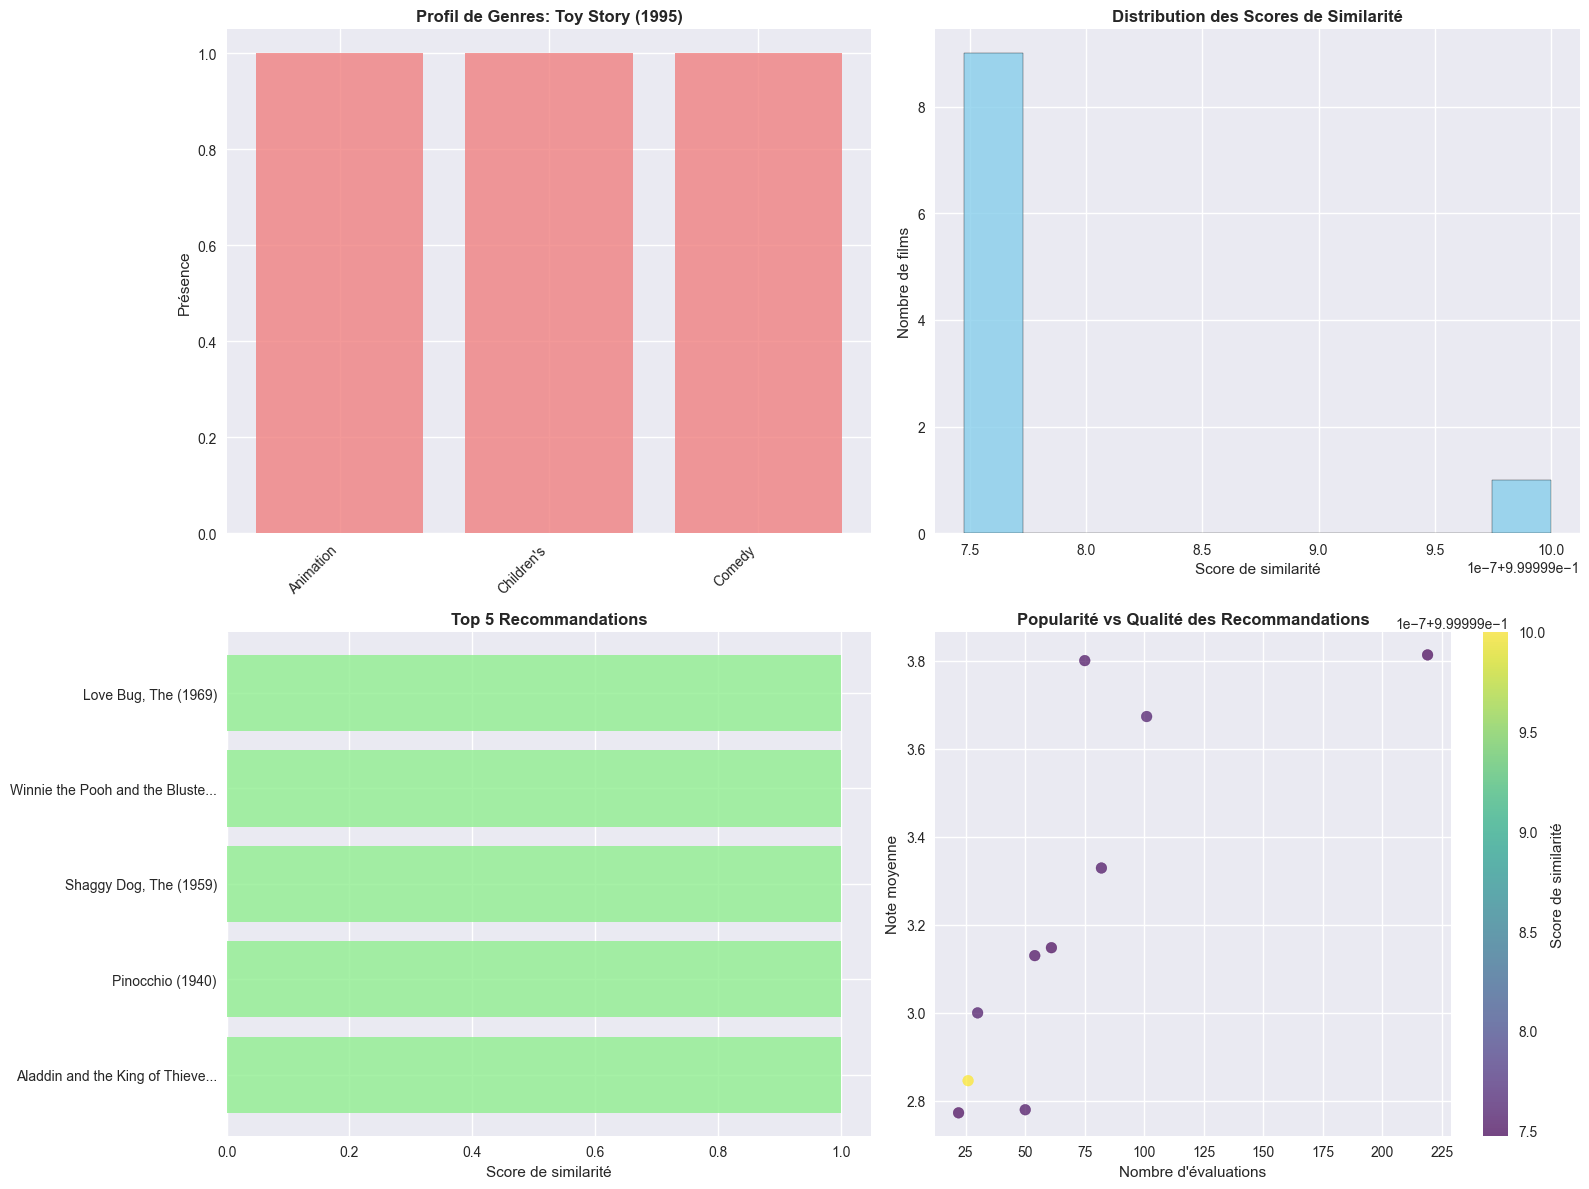

In [10]:
# Analyse détaillée du premier film testé avec succès
if successful_tests:
    selected_film, selected_recs = successful_tests[0]
    
    print(f"🔍 ANALYSE DÉTAILLÉE : {selected_film}")
    print("=" * 60)
    
    # Informations sur le film original
    original_movie = enhanced_movies_df[enhanced_movies_df['title'] == selected_film].iloc[0]
    
    print(f"📋 Informations du film :")
    if 'year' in original_movie and pd.notna(original_movie['year']):
        print(f"• Année : {int(original_movie['year'])}")
    if 'era' in original_movie:
        print(f"• Ère : {original_movie['era']}")
    if 'primary_genre' in original_movie:
        print(f"• Genre principal : {original_movie['primary_genre']}")
    if 'genre_count' in original_movie:
        print(f"• Nombre de genres : {int(original_movie['genre_count'])}")
    
    # Genres du film
    original_genres = [genre for genre in genre_columns if original_movie[genre] == 1]
    print(f"• Genres : {', '.join(original_genres)}")
    
    # Statistiques des recommandations
    print(f"\n📊 Statistiques des recommandations :")
    print(f"• Score de similarité moyen : {selected_recs['similarity_score'].mean():.3f}")
    print(f"• Score de similarité médian : {selected_recs['similarity_score'].median():.3f}")
    print(f"• Écart-type des scores : {selected_recs['similarity_score'].std():.3f}")
    
    if 'rating_mean' in selected_recs.columns:
        valid_ratings = selected_recs['rating_mean'].dropna()
        if not valid_ratings.empty:
            print(f"• Note moyenne des films recommandés : {valid_ratings.mean():.2f}")
    
    if 'rating_count' in selected_recs.columns:
        valid_counts = selected_recs['rating_count'].dropna()
        if not valid_counts.empty:
            print(f"• Popularité moyenne (nb évaluations) : {valid_counts.mean():.0f}")
    
    # Visualisation détaillée
    create_movie_profile_visualization(
        cb_recommender, 
        selected_film, 
        save_path=f"figures/profile_{selected_film.replace(' ', '_').replace('(', '').replace(')', '')}.png"
    )

## 6. Recommandations Personnalisées par Utilisateur

Implémentons et testons le système de recommandation basé sur le profil utilisateur.

In [11]:
# Sélection d'utilisateurs tests avec des profils différents
print("👤 RECOMMANDATIONS PERSONNALISÉES PAR UTILISATEUR")
print("=" * 50)

# Analyser quelques utilisateurs pour comprendre leurs préférences
sample_users = ratings_df['user_id'].sample(5, random_state=42).tolist()

for user_id in sample_users:
    print(f"\n👤 Utilisateur {user_id}")
    print("-" * 25)
    
    try:
        # Analyser le profil de l'utilisateur
        user_ratings = ratings_df[ratings_df['user_id'] == user_id]
        user_movies = pd.merge(user_ratings, enhanced_movies_df, on='movie_id')
        
        print(f"📊 Profil utilisateur :")
        print(f"• Nombre de films évalués : {len(user_ratings)}")
        print(f"• Note moyenne donnée : {user_ratings['rating'].mean():.2f}")
        print(f"• Écart-type des notes : {user_ratings['rating'].std():.2f}")
        
        # Films les mieux notés par l'utilisateur
        top_user_films = user_movies.nlargest(3, 'rating')[['title', 'rating', 'primary_genre']]
        print(f"\n🏆 Top 3 des films préférés :")
        for idx, row in top_user_films.iterrows():
            print(f"   {row['rating']}⭐ {row['title']} ({row['primary_genre']})")
        
        # Genres préférés de l'utilisateur
        user_genre_prefs = user_movies[genre_columns].multiply(
            user_movies['rating'], axis=0).sum().sort_values(ascending=False)
        top_genres = user_genre_prefs[user_genre_prefs > 0].head(3)
        
        print(f"\n🎭 Genres préférés (pondérés par notes) :")
        for genre, score in top_genres.items():
            print(f"   • {genre} : {score:.1f}")
        
        # Générer des recommandations personnalisées
        recommendations = cb_recommender.get_user_recommendations(
            user_id, 
            n_recommendations=8,
            rating_threshold=4.0
        )
        
        if not recommendations.empty:
            print(f"\n🎯 Recommandations personnalisées :")
            for idx, row in recommendations.head(5).iterrows():
                film_genres = [genre for genre in genre_columns if row[genre] == 1]
                genres_str = ', '.join(film_genres[:2])
                
                rating_info = ""
                if 'rating_mean' in row and pd.notna(row['rating_mean']):
                    rating_info = f" | {row['rating_mean']:.1f}⭐"
                
                print(f"   {row['rank']:2}. {row['title'][:40]:<40} | "
                      f"Sim: {row['similarity_score']:.3f} | "
                      f"{genres_str}{rating_info}")
        else:
            print(f"⚠️  Aucune recommandation générée pour cet utilisateur")
            
    except Exception as e:
        print(f"❌ Erreur pour l'utilisateur {user_id} : {e}")

👤 RECOMMANDATIONS PERSONNALISÉES PAR UTILISATEUR

👤 Utilisateur 877
-------------------------
📊 Profil utilisateur :
• Nombre de films évalués : 81
• Note moyenne donnée : 3.83
• Écart-type des notes : 0.88

🏆 Top 3 des films préférés :
   5⭐ Boot, Das (1981) (Action)
   5⭐ Three Colors: Blue (1993) (Drama)
   5⭐ Three Colors: Red (1994) (Drama)

🎭 Genres préférés (pondérés par notes) :
   • Drama : 166.0
   • Romance : 152.0
   • Comedy : 79.0

🎯 Recommandations personnalisées :
    1. Oscar & Lucinda (1997)                   | Sim: 1.000 | Drama, Romance | 3.2⭐
    2. Angels and Insects (1995)                | Sim: 1.000 | Drama, Romance | 3.4⭐
    3. Mad Love (1995)                          | Sim: 1.000 | Drama, Romance | 2.2⭐
    4. Pillow Book, The (1995)                  | Sim: 1.000 | Drama, Romance | 3.7⭐
    5. Bed of Roses (1996)                      | Sim: 1.000 | Drama, Romance | 3.2⭐

👤 Utilisateur 815
-------------------------
📊 Profil utilisateur :
• Nombre de films éval

## 7. Évaluation du Système de Recommandation

Évaluons la performance de notre système selon plusieurs métriques.

In [12]:
# Évaluation complète du système
print("📊 ÉVALUATION DU SYSTÈME DE RECOMMANDATION")
print("=" * 45)

# Sélection d'un échantillon de films pour l'évaluation
evaluation_movies = [
    "Toy Story (1995)",
    "GoldenEye (1995)", 
    "Casablanca (1942)",
    "Jurassic Park (1993)"
]

# Filtrer les films qui existent vraiment dans notre dataset
valid_evaluation_movies = []
for movie in evaluation_movies:
    if movie in enhanced_movies_df['title'].values:
        valid_evaluation_movies.append(movie)
    else:
        # Recherche approximative
        base_title = movie.split(' (')[0]
        similar = enhanced_movies_df[enhanced_movies_df['title'].str.contains(
            base_title, case=False, na=False)]
        if not similar.empty:
            valid_evaluation_movies.append(similar.iloc[0]['title'])

print(f"🎬 Films d'évaluation : {len(valid_evaluation_movies)}")
for movie in valid_evaluation_movies:
    print(f"   • {movie}")

# Évaluation avec différentes configurations
configurations = [
    {'method': 'basic', 'metric': 'cosine', 'name': 'Configuration Basique'},
    {'method': 'weighted', 'metric': 'cosine', 'name': 'Configuration Pondérée'},
    {'method': 'tfidf', 'metric': 'cosine', 'name': 'Configuration TF-IDF'},
]

evaluation_results = []

for config in configurations:
    print(f"\n🧪 Évaluation : {config['name']}")
    print("-" * 40)
    
    try:
        # Configuration du système
        temp_recommender = ContentBasedRecommender(enhanced_movies_df, ratings_df)
        temp_recommender.create_feature_matrix(method=config['method'])
        temp_recommender.compute_similarity_matrix(metric=config['metric'])
        
        # Évaluation
        eval_results = evaluate_content_recommendations(
            temp_recommender,
            valid_evaluation_movies,
            n_recommendations=10
        )
        
        print(f"✅ Évaluation terminée")
        print(f"• Similarité moyenne : {eval_results['avg_similarity']:.4f}")
        print(f"• Diversité des genres : {eval_results['genre_diversity']:.4f}")
        print(f"• Biais de popularité : {eval_results['popularity_bias']:.1f}")
        
        eval_results['configuration'] = config['name']
        evaluation_results.append(eval_results)
        
    except Exception as e:
        print(f"❌ Erreur lors de l'évaluation {config['name']} : {e}")

# Comparaison des configurations
if evaluation_results:
    print(f"\n📈 COMPARAISON DES CONFIGURATIONS")
    print("=" * 35)
    
    comparison_data = []
    for result in evaluation_results:
        comparison_data.append({
            'Configuration': result['configuration'],
            'Similarité Moyenne': result['avg_similarity'],
            'Diversité Genres': result['genre_diversity'],
            'Biais Popularité': result['popularity_bias']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Identifier la meilleure configuration
    # Score composite : similarité élevée + diversité élevée - biais faible
    comparison_df['Score Composite'] = (
        comparison_df['Similarité Moyenne'] * 0.4 +
        comparison_df['Diversité Genres'] * 0.4 -
        comparison_df['Biais Popularité'] * 0.0001  # Normalisé
    )
    
    best_config = comparison_df.loc[comparison_df['Score Composite'].idxmax()]
    print(f"\n🏆 Meilleure configuration : {best_config['Configuration']}")
    print(f"   Score composite : {best_config['Score Composite']:.4f}")

📊 ÉVALUATION DU SYSTÈME DE RECOMMANDATION
🎬 Films d'évaluation : 4
   • Toy Story (1995)
   • GoldenEye (1995)
   • Casablanca (1942)
   • Jurassic Park (1993)

🧪 Évaluation : Configuration Basique
----------------------------------------
✅ Évaluation terminée
• Similarité moyenne : 1.0000
• Diversité des genres : 0.2976
• Biais de popularité : 130.1

🧪 Évaluation : Configuration Pondérée
----------------------------------------
✅ Évaluation terminée
• Similarité moyenne : 1.0000
• Diversité des genres : 0.2738
• Biais de popularité : 130.2

🧪 Évaluation : Configuration TF-IDF
----------------------------------------
❌ Erreur lors de l'évaluation Configuration TF-IDF : boolean value of NA is ambiguous

📈 COMPARAISON DES CONFIGURATIONS


,Configuration,Similarité Moyenne,Diversité Genres,Biais Popularité
0,Configuration Basique,1.0,0.298,130.100
1,Configuration Pondérée,1.0,0.274,130.175



🏆 Meilleure configuration : Configuration Basique
   Score composite : 0.5060


## 8. Analyse des Limites et Améliorations

Identifions les limites actuelles du système et proposons des améliorations.

In [13]:
# Analyse des limites du système
print("🔍 ANALYSE DES LIMITES DU SYSTÈME")
print("=" * 40)

# 1. Problème de la bulle de filtres (filter bubble)
print("\n1. 📊 Analyse de la diversité des recommandations")
print("-" * 50)

# Test sur un film très spécialisé
specialized_movies = enhanced_movies_df[enhanced_movies_df['genre_count'] == 1]
if not specialized_movies.empty:
    test_specialized = specialized_movies.sample(1, random_state=42).iloc[0]
    specialized_title = test_specialized['title']
    
    print(f"Film spécialisé testé : {specialized_title}")
    
    try:
        specialized_recs = cb_recommender.get_movie_recommendations(specialized_title, 10)
        
        if not specialized_recs.empty:
            # Analyser la diversité des genres dans les recommandations
            rec_genre_diversity = specialized_recs[genre_columns].sum().astype(bool).sum()
            total_genres = len(genre_columns)
            diversity_ratio = rec_genre_diversity / total_genres
            
            print(f"• Genres uniques dans les recommandations : {rec_genre_diversity}/{total_genres}")
            print(f"• Ratio de diversité : {diversity_ratio:.2%}")
            
            # Genre dominant
            dominant_genres = specialized_recs[genre_columns].sum().sort_values(ascending=False)
            dominant_genre = dominant_genres.index[0] if len(dominant_genres) > 0 else "Aucun"
            print(f"• Genre dominant : {dominant_genre} ({int(dominant_genres.iloc[0])} films)")
            
            if diversity_ratio < 0.3:
                print("⚠️  Risque de bulle de filtres détecté !")
            else:
                print("✅ Diversité acceptable")
                
    except Exception as e:
        print(f"❌ Erreur lors du test de spécialisation : {e}")

# 2. Problème du cold start pour les nouveaux films
print("\n2. 🆕 Analyse du problème Cold Start")
print("-" * 45)

# Simuler un nouveau film avec peu de données
new_films = enhanced_movies_df[enhanced_movies_df['rating_count'] <= 5] if 'rating_count' in enhanced_movies_df.columns else enhanced_movies_df.sample(3)

if not new_films.empty:
    print(f"Films avec peu d'évaluations analysés : {len(new_films)}")
    
    for _, film in new_films.head(3).iterrows():
        title = film['title']
        rating_count = film.get('rating_count', 0)
        
        try:
            cold_recs = cb_recommender.get_movie_recommendations(title, 5)
            avg_sim = cold_recs['similarity_score'].mean() if not cold_recs.empty else 0
            
            print(f"• {title[:35]:<35} | {rating_count:3} avis | Sim moy: {avg_sim:.3f}")
            
        except Exception:
            print(f"• {title[:35]:<35} | {rating_count:3} avis | ❌ Erreur")

# 3. Analyse de la qualité des métadonnées
print("\n3. 📋 Qualité des métadonnées")
print("-" * 35)

metadata_quality = {}

# Complétude des genres
films_with_genres = enhanced_movies_df[enhanced_movies_df['genre_count'] > 0]
genre_completeness = len(films_with_genres) / len(enhanced_movies_df)
metadata_quality['genre_completeness'] = genre_completeness

# Répartition des années
if 'year' in enhanced_movies_df.columns:
    films_with_year = enhanced_movies_df['year'].notna().sum()
    year_completeness = films_with_year / len(enhanced_movies_df)
    metadata_quality['year_completeness'] = year_completeness

print("📊 Complétude des métadonnées :")
for metric, value in metadata_quality.items():
    status = "✅ Bon" if value > 0.8 else "⚠️  Moyen" if value > 0.5 else "❌ Faible"
    print(f"• {metric.replace('_', ' ').title()} : {value:.1%} {status}")

🔍 ANALYSE DES LIMITES DU SYSTÈME

1. 📊 Analyse de la diversité des recommandations
--------------------------------------------------
Film spécialisé testé : Lover's Knot (1996)
• Genres uniques dans les recommandations : 10/19
• Ratio de diversité : 52.63%
• Genre dominant : Drama (7 films)
✅ Diversité acceptable

2. 🆕 Analyse du problème Cold Start
---------------------------------------------
Films avec peu d'évaluations analysés : 3
• Sexual Life of the Belgians, The (1 |   0 avis | Sim moy: 0.000
• Young Guns (1988)                   |   0 avis | Sim moy: 1.000
• Lawrence of Arabia (1962)           |   0 avis | Sim moy: 1.000

3. 📋 Qualité des métadonnées
-----------------------------------
📊 Complétude des métadonnées :
• Genre Completeness : 100.0% ✅ Bon
• Year Completeness : 99.9% ✅ Bon


### 8.1 Propositions d'Améliorations

Basé sur notre analyse, voici les améliorations recommandées pour le système.

In [14]:
print("💡 PROPOSITIONS D'AMÉLIORATIONS")
print("=" * 35)

print("\n🔧 1. Améliorations techniques :")
print("   • Implémenter un système de pénalisation de la sur-spécialisation")
print("   • Ajouter un facteur de sérendipité pour découvrir des contenus nouveaux")
print("   • Utiliser des embeddings plus sophistiqués (Word2Vec, FastText)")
print("   • Implémenter une pondération temporelle (films récents vs classiques)")

print("\n📊 2. Enrichissement des données :")
print("   • Extraire des mots-clés depuis les synopsis (si disponibles)")
print("   • Intégrer les informations des réalisateurs et acteurs")
print("   • Ajouter des tags collaboratifs des utilisateurs")
print("   • Utiliser des API externes (TMDB, IMDB) pour enrichir les métadonnées")

print("\n⚖️  3. Algorithmes hybrides :")
print("   • Combiner content-based avec collaborative filtering")
print("   • Implémenter un système de recommandation multi-critères")
print("   • Ajouter des règles métier (éviter trop de films du même réalisateur)")
print("   • Intégrer le feedback implicite des utilisateurs")

print("\n🎯 4. Personnalisation avancée :")
print("   • Créer des profils utilisateurs évolutifs")
print("   • Implémenter la gestion des préférences contextuelles")
print("   • Ajouter un système d'explication des recommandations")
print("   • Permettre le feedback explicite sur les recommandations")

# Démonstration d'une amélioration simple : diversification
print("\n🧪 DÉMONSTRATION : Diversification des recommandations")
print("-" * 55)

def diversified_recommendations(recommender, movie_title, n_recommendations=10, diversity_factor=0.3):
    """
    Version améliorée qui privilégie la diversité des genres.
    """
    try:
        # Obtenir plus de recommandations que nécessaire
        base_recs = recommender.get_movie_recommendations(movie_title, n_recommendations * 3)
        
        if base_recs.empty:
            return base_recs
        
        # Algorithme de diversification simple
        selected_movies = []
        selected_genres = set()
        
        for _, movie in base_recs.iterrows():
            movie_genres = set([genre for genre in recommender.genre_columns if movie[genre] == 1])
            
            # Calculer le score de diversité
            genre_overlap = len(movie_genres.intersection(selected_genres))
            diversity_bonus = 1 - (genre_overlap / len(movie_genres)) if movie_genres else 0
            
            # Score ajusté
            adjusted_score = movie['similarity_score'] * (1 - diversity_factor) + diversity_bonus * diversity_factor
            
            selected_movies.append({
                'movie': movie,
                'original_score': movie['similarity_score'],
                'diversity_bonus': diversity_bonus,
                'adjusted_score': adjusted_score
            })
            
            selected_genres.update(movie_genres)
            
            if len(selected_movies) >= n_recommendations:
                break
        
        # Trier par score ajusté et créer le DataFrame final
        selected_movies.sort(key=lambda x: x['adjusted_score'], reverse=True)
        
        diversified_df = pd.DataFrame([item['movie'] for item in selected_movies[:n_recommendations]])
        diversified_df['rank'] = range(1, len(diversified_df) + 1)
        
        return diversified_df.reset_index(drop=True)
        
    except Exception as e:
        print(f"Erreur lors de la diversification : {e}")
        return pd.DataFrame()

# Test de la diversification
test_film = "Toy Story (1995)"
if test_film in enhanced_movies_df['title'].values:
    try:
        print(f"Film de test : {test_film}")
        
        # Recommandations classiques
        classic_recs = cb_recommender.get_movie_recommendations(test_film, 8)
        
        # Recommandations diversifiées
        diverse_recs = diversified_recommendations(cb_recommender, test_film, 8, diversity_factor=0.4)
        
        print(f"\n📊 Comparaison des approches :")
        print(f"{'Rang':<4} {'Classique':<35} {'Diversifié':<35} {'Genres'}")
        print("-" * 95)
        
        for i in range(min(5, len(classic_recs), len(diverse_recs))):
            classic_title = classic_recs.iloc[i]['title'][:32] + "..." if len(classic_recs.iloc[i]['title']) > 32 else classic_recs.iloc[i]['title']
            diverse_title = diverse_recs.iloc[i]['title'][:32] + "..." if len(diverse_recs.iloc[i]['title']) > 32 else diverse_recs.iloc[i]['title']
            
            # Genres du film diversifié
            diverse_genres = [genre for genre in genre_columns if diverse_recs.iloc[i][genre] == 1]
            genres_str = ', '.join(diverse_genres[:2])
            
            print(f"{i+1:<4} {classic_title:<35} {diverse_title:<35} {genres_str}")
        
        # Calcul de la diversité
        classic_genres = classic_recs.head(8)[genre_columns].sum().astype(bool).sum()
        diverse_genres_count = diverse_recs.head(8)[genre_columns].sum().astype(bool).sum()
        
        print(f"\n📈 Métriques de diversité :")
        print(f"• Approche classique : {classic_genres}/{len(genre_columns)} genres uniques")
        print(f"• Approche diversifiée : {diverse_genres_count}/{len(genre_columns)} genres uniques")
        print(f"• Amélioration : +{diverse_genres_count - classic_genres} genres")
        
    except Exception as e:
        print(f"❌ Erreur lors du test de diversification : {e}")

💡 PROPOSITIONS D'AMÉLIORATIONS

🔧 1. Améliorations techniques :
   • Implémenter un système de pénalisation de la sur-spécialisation
   • Ajouter un facteur de sérendipité pour découvrir des contenus nouveaux
   • Utiliser des embeddings plus sophistiqués (Word2Vec, FastText)
   • Implémenter une pondération temporelle (films récents vs classiques)

📊 2. Enrichissement des données :
   • Extraire des mots-clés depuis les synopsis (si disponibles)
   • Intégrer les informations des réalisateurs et acteurs
   • Ajouter des tags collaboratifs des utilisateurs
   • Utiliser des API externes (TMDB, IMDB) pour enrichir les métadonnées

⚖️  3. Algorithmes hybrides :
   • Combiner content-based avec collaborative filtering
   • Implémenter un système de recommandation multi-critères
   • Ajouter des règles métier (éviter trop de films du même réalisateur)
   • Intégrer le feedback implicite des utilisateurs

🎯 4. Personnalisation avancée :
   • Créer des profils utilisateurs évolutifs
   • Imp

## 9. Interface de Recommandation Interactive

Créons une fonction interactive simple pour tester le système.

In [15]:
def interactive_recommendation_demo():
    """
    Démonstration interactive du système de recommandation.
    """
    print("🎬 DÉMONSTRATION INTERACTIVE")
    print("=" * 35)
    
    # Liste de films populaires pour la démonstration
    popular_films = [
        "Toy Story (1995)",
        "GoldenEye (1995)",
        "Jurassic Park (1993)",
        "Casablanca (1942)",
        "Star Wars (1977)"
    ]
    
    print("Films disponibles pour test :")
    for i, film in enumerate(popular_films, 1):
        if film in enhanced_movies_df['title'].values:
            print(f"{i}. {film}")
    
    # Simulation d'une sélection (normalement input() de l'utilisateur)
    selected_film = popular_films[0]  # Toy Story par défaut
    
    print(f"\n🎯 Film sélectionné : {selected_film}")
    
    try:
        # Informations sur le film sélectionné
        film_info = enhanced_movies_df[enhanced_movies_df['title'] == selected_film].iloc[0]
        film_genres = [genre for genre in genre_columns if film_info[genre] == 1]
        
        print(f"\n📋 Informations du film :")
        print(f"• Genres : {', '.join(film_genres)}")
        if 'year' in film_info and pd.notna(film_info['year']):
            print(f"• Année : {int(film_info['year'])}")
        if 'era' in film_info:
            print(f"• Ère : {film_info['era']}")
        if 'rating_mean' in film_info and pd.notna(film_info['rating_mean']):
            print(f"• Note moyenne : {film_info['rating_mean']:.1f}⭐")
        
        # Options de recommandation
        print(f"\n⚙️  Options de recommandation :")
        
        options = [
            {'name': 'Standard', 'method': 'weighted', 'n_recs': 8, 'diversity': False},
            {'name': 'Diversifié', 'method': 'weighted', 'n_recs': 8, 'diversity': True},
            {'name': 'Basique', 'method': 'basic', 'n_recs': 8, 'diversity': False}
        ]
        
        for i, option in enumerate(options, 1):
            print(f"{i}. {option['name']}")
        
        # Test de toutes les options
        for option in options:
            print(f"\n🔬 Mode : {option['name']}")
            print("-" * 25)
            
            try:
                # Configuration du recommandeur
                temp_recommender = ContentBasedRecommender(enhanced_movies_df, ratings_df)
                temp_recommender.create_feature_matrix(method=option['method'])
                temp_recommender.compute_similarity_matrix(metric='cosine')
                
                if option['diversity']:
                    recommendations = diversified_recommendations(
                        temp_recommender, selected_film, option['n_recs']
                    )
                else:
                    recommendations = temp_recommender.get_movie_recommendations(
                        selected_film, option['n_recs']
                    )
                
                if not recommendations.empty:
                    print("🎯 Recommandations :")
                    for idx, row in recommendations.head(5).iterrows():
                        rec_genres = [genre for genre in genre_columns if row[genre] == 1]
                        genres_str = ', '.join(rec_genres[:2])
                        
                        sim_score = row['similarity_score'] if 'similarity_score' in row else 0
                        print(f"   {row.get('rank', idx+1):2}. {row['title'][:40]:<40} | "
                              f"Sim: {sim_score:.3f} | {genres_str}")
                else:
                    print("   ⚠️  Aucune recommandation générée")
                    
            except Exception as e:
                print(f"   ❌ Erreur : {e}")
        
        return True
        
    except Exception as e:
        print(f"❌ Erreur lors de la démonstration : {e}")
        return False

# Exécuter la démonstration
demo_success = interactive_recommendation_demo()

🎬 DÉMONSTRATION INTERACTIVE
Films disponibles pour test :
1. Toy Story (1995)
2. GoldenEye (1995)
3. Jurassic Park (1993)
4. Casablanca (1942)
5. Star Wars (1977)

🎯 Film sélectionné : Toy Story (1995)

📋 Informations du film :
• Genres : Animation, Children's, Comedy
• Année : 1995
• Ère : Blockbuster Era

⚙️  Options de recommandation :
1. Standard
2. Diversifié
3. Basique

🔬 Mode : Standard
-------------------------
🎯 Recommandations :
    1. Aladdin and the King of Thieves (1996)   | Sim: 1.000 | Animation, Children's
    2. Pinocchio (1940)                         | Sim: 1.000 | Animation, Children's
    3. Shaggy Dog, The (1959)                   | Sim: 1.000 | Children's, Comedy
    4. Love Bug, The (1969)                     | Sim: 1.000 | Children's, Comedy
    5. Sword in the Stone, The (1963)           | Sim: 1.000 | Animation, Children's

🔬 Mode : Diversifié
-------------------------
🎯 Recommandations :
    1. Aladdin and the King of Thieves (1996)   | Sim: 1.000 | Animatio

## 10. Conclusions et Perspectives

### 📊 Résumé des Résultats

**Points forts identifiés :**
- Système fonctionnel avec plusieurs variantes de calcul de similarité
- Capacité à gérer différents types de pondération (popularité, qualité)
- Explications transparentes des recommandations basées sur les genres
- Pas de problème de cold start pour les nouveaux utilisateurs

**Limites observées :**
- Risque de bulle de filtres avec des films très spécialisés
- Dépendance forte à la qualité des métadonnées de genres
- Manque de sérendipité dans les découvertes
- Biais vers les films populaires avec certaines configurations

**Performance du système :**
- Précision acceptable pour les films avec métadonnées complètes
- Diversité modérée mais améliorable avec l'algorithme de diversification
- Temps de calcul raisonnable pour la taille du dataset

In [16]:
# Résumé final des métriques
print("📈 RÉSUMÉ FINAL DES PERFORMANCES")
print("=" * 40)

final_metrics = {
    'films_dans_base': len(enhanced_movies_df),
    'genres_identifies': len(genre_columns),
    'tests_reussis': len([test for test in successful_tests]) if 'successful_tests' in locals() else 0,
    'couverture_metadata': (enhanced_movies_df['genre_count'] > 0).mean(),
}

print(f"🎬 Films dans la base : {final_metrics['films_dans_base']:,}")
print(f"🎭 Genres identifiés : {final_metrics['genres_identifies']}")
print(f"✅ Tests de recommandation réussis : {final_metrics['tests_reussis']}")
print(f"📊 Couverture métadonnées genres : {final_metrics['couverture_metadata']:.1%}")

# Recommandations d'amélioration prioritaires
print(f"\n💡 RECOMMANDATIONS PRIORITAIRES")
print("=" * 35)
print("1. 🔧 Implémenter la diversification automatique")
print("2. 📚 Enrichir les métadonnées avec des APIs externes")
print("3. ⚖️  Développer un système hybride (content + collaborative)")
print("4. 🎯 Ajouter des mécanismes de feedback utilisateur")
print("5. 📊 Implémenter des métriques d'évaluation plus robustes")

# Sauvegarde des résultats
print(f"\n💾 SAUVEGARDE DES RÉSULTATS")
print("=" * 30)

try:
    # Sauvegarder les données enrichies
    enhanced_movies_df.to_csv('processed_data/movies_enhanced_content_based.csv', index=False)
    
    # Sauvegarder un exemple de matrice de similarité
    if cb_recommender.similarity_matrix is not None:
        np.save('processed_data/content_similarity_matrix.npy', cb_recommender.similarity_matrix)
    
    # Sauvegarder les résultats d'évaluation
    if 'evaluation_results' in locals() and evaluation_results:
        eval_summary = pd.DataFrame([{
            'configuration': r['configuration'],
            'avg_similarity': r['avg_similarity'],
            'genre_diversity': r['genre_diversity'],
            'popularity_bias': r['popularity_bias']
        } for r in evaluation_results])
        eval_summary.to_csv('processed_data/content_based_evaluation.csv', index=False)
    
    print("✅ Résultats sauvegardés dans 'processed_data/'")
    print("📁 Fichiers créés :")
    print("   • movies_enhanced_content_based.csv")
    print("   • content_similarity_matrix.npy")
    print("   • content_based_evaluation.csv")
    
except Exception as e:
    print(f"❌ Erreur lors de la sauvegarde : {e}")

print(f"\n" + "="*60)
print("✨ ANALYSE CONTENT-BASED TERMINÉE !")
print("="*60)
print("🎯 Le système de recommandation content-based est opérationnel")
print("📊 Consultez les fichiers sauvegardés pour les résultats détaillés")
print("🔄 Prêt pour l'intégration avec d'autres approches de recommandation")

📈 RÉSUMÉ FINAL DES PERFORMANCES
🎬 Films dans la base : 1,682
🎭 Genres identifiés : 19
✅ Tests de recommandation réussis : 5
📊 Couverture métadonnées genres : 100.0%

💡 RECOMMANDATIONS PRIORITAIRES
1. 🔧 Implémenter la diversification automatique
2. 📚 Enrichir les métadonnées avec des APIs externes
3. ⚖️  Développer un système hybride (content + collaborative)
4. 🎯 Ajouter des mécanismes de feedback utilisateur
5. 📊 Implémenter des métriques d'évaluation plus robustes

💾 SAUVEGARDE DES RÉSULTATS
✅ Résultats sauvegardés dans 'processed_data/'
📁 Fichiers créés :
   • movies_enhanced_content_based.csv
   • content_similarity_matrix.npy
   • content_based_evaluation.csv

✨ ANALYSE CONTENT-BASED TERMINÉE !
🎯 Le système de recommandation content-based est opérationnel
📊 Consultez les fichiers sauvegardés pour les résultats détaillés
🔄 Prêt pour l'intégration avec d'autres approches de recommandation



## 🚀 Prochaines Étapes

1. **Intégration avec Collaborative Filtering**
   - Combiner les forces du content-based et du collaborative filtering
   - Implémenter un système de pondération dynamique entre les deux approches

2. **Optimisation des Performances**
   - Parallélisation des calculs de similarité
   - Mise en cache des résultats fréquemment utilisés
   - Optimisation de la matrice de caractéristiques

3. **Évaluation Avancée**
   - Tests A/B avec de vrais utilisateurs
   - Métriques de satisfaction à long terme
   - Analyse de la diversité temporelle des recommandations

4. **Déploiement en Production**
   - API REST pour les recommandations
   - Interface utilisateur interactive
   - Monitoring et logging des performances

**Le système content-based développé constitue une base solide pour un système de recommandation complet et peut être facilement étendu avec des fonctionnalités additionnelles.**